<a href="https://colab.research.google.com/github/xhu19/edge-computer-vision/blob/master/ECV_assignment2_Pacman_2versions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Ideas for Training Pacman Model:


Rewards to train:

* Avoid Ghosts
* Eat the energizer pellets
* Go Left
* Go Right
* Randomly go (right| left)
* Eat regular pellets
* Find open space (no pellets, no ghosts)
* Train it to find a new item: [Step 1- Eat pellet, A. go toward ghost, B. go to empty space, C. eat another pellet ]

- Example of Rewards:  https://www.digitalocean.com/community/tutorials/how-to-build-atari-bot-with-openai-gym

- https://www.digitalocean.com/community/tutorials/how-to-build-atari-bot-with-openai-gym


In [152]:
from random import choices

In [153]:
actions = ["eat pellet", "go toward ghost", "empty space"]
print(choices(actions))

['empty space']


In [154]:
def actions_list(actions):
    while True:
        for action in actions:
            yield choices(actions)


In [155]:
actions = ["eat pellet", "go toward ghost", "empty space"]
actions2 = ["left", "right", "stay"]

In [156]:
action = actions_list(actions2)

In [157]:
for _ in range(5):
    print(next(action))

['left']
['left']
['stay']
['stay']
['right']


#### install dependancies, takes around 45 seconds

Rendering Dependancies



In [158]:
#remove " > /dev/null 2>&1" to see what is going on under the hood
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

Pacman Dependancies

In [159]:
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1

Requirement already up-to-date: setuptools in /usr/local/lib/python3.6/dist-packages (47.3.1)


#### Imports and Helper functions


In [160]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay

In [161]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

In [162]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

#### Pacman!

In [163]:
env = wrap_env(gym.make("MsPacman-v0"))

In [164]:
#check out the pacman action space!
print(env.action_space)

Discrete(9)


In [165]:
observation = env.reset()

while True:
  
    env.render()
    
    #your agent goes here
    action = env.action_space.sample() 
         
    observation, reward, done, info = env.step(action) 
        
    if done: 
      break;
            
env.close()
show_video()

## New Version


In [3]:
%tensorflow_version 1.x
import tensorflow as tf
tf.__version__

TensorFlow 1.x selected.


'1.15.2'

In [2]:
import numpy as np
import gym
import tensorflow as tf
from tensorflow.contrib.layers import flatten, conv2d, fully_connected
from collections import deque, Counter
import random
from datetime import datetime


In [3]:
color = np.array([210, 164, 74]).mean()


#prepro (210, 160, 3) uint8 frame into 7040 (88x80) 1D float vector 

def preprocess_observation(obs):

    # Crop and resize the image
    img = obs[1:176:2, ::2]

    # Convert the image to greyscale
    img = img.mean(axis=2)

    # Improve image contrast
    img[img==color] = 0

    # Next we normalize the image from -1 to +1
    img = (img - 128) / 128 - 1

    return img.reshape(88,80,1)

9
['NOOP', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'UPRIGHT', 'UPLEFT', 'DOWNRIGHT', 'DOWNLEFT']


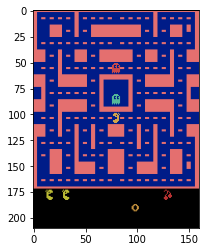

In [4]:
env = gym.make("MsPacman-v0")
n_outputs = env.action_space.n
print(n_outputs)
print(env.env.get_action_meanings())

observation = env.reset()

import tensorflow as tf
import matplotlib.pyplot as plt


for i in range(22):
  
  if i > 20:
    plt.imshow(observation)
    plt.show()

  observation, _, _, _ = env.step(1)



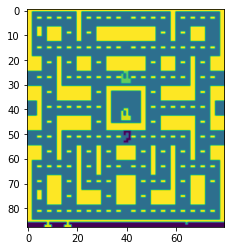

(210, 160, 3)
(88, 80)


In [5]:

#Take a look at the preprocessed inputs in greyscale
#Let's compare the original and preprocessed tensors.

obs_preprocessed = preprocess_observation(observation).reshape(88,80)
plt.imshow(obs_preprocessed)
plt.show()
print(observation.shape)
print(obs_preprocessed.shape)

In [6]:
tf.compat.v1.reset_default_graph()
#Reset is technically not necessary if variables done  in TF2
#https://github.com/ageron/tf2_course/issues/8

def q_network(X, name_scope):
    
    # Initialize layers
    initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=2.0)

    with tf.compat.v1.variable_scope(name_scope) as scope: 


        # initialize the convolutional layers
        layer_1 = conv2d(X, num_outputs=32, kernel_size=(8,8), stride=4, padding='SAME', weights_initializer=initializer) 
        tf.compat.v1.summary.histogram('layer_1',layer_1)
        
        layer_2 = conv2d(layer_1, num_outputs=64, kernel_size=(4,4), stride=2, padding='SAME', weights_initializer=initializer)
        tf.compat.v1.summary.histogram('layer_2',layer_2)
        
        layer_3 = conv2d(layer_2, num_outputs=64, kernel_size=(3,3), stride=1, padding='SAME', weights_initializer=initializer)
        tf.compat.v1.summary.histogram('layer_3',layer_3)
        
        # Flatten the result of layer_3 before feeding to the fully connected layer
        flat = flatten(layer_3)
        # Insert fully connected layer
        fc = fully_connected(flat, num_outputs=128, weights_initializer=initializer)
        tf.compat.v1.summary.histogram('fc',fc)
        #Add final output layer
        output = fully_connected(fc, num_outputs=n_outputs, activation_fn=None, weights_initializer=initializer)
        tf.compat.v1.summary.histogram('output',output)
        

        # Vars will store the parameters of the network such as weights
        vars = {v.name[len(scope.name):]: v for v in tf.compat.v1.get_collection(key=tf.compat.v1.GraphKeys.TRAINABLE_VARIABLES, scope=scope.name)} 
        #Return both variables and outputs together
        return vars, output

In [7]:
epsilon = 0.5
eps_min = 0.05
eps_max = 1.0
eps_decay_steps = 500000

#
def epsilon_greedy(action, step):
    p = np.random.random(1).squeeze() #1D entries returned using squeeze
    epsilon = max(eps_min, eps_max - (eps_max-eps_min) * step/eps_decay_steps) #Decaying policy with more steps
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)
    else:
        return action


In [8]:
buffer_len = 20000
#Buffer is made from a deque - double ended queue
exp_buffer = deque(maxlen=buffer_len)

In [9]:
def sample_memories(batch_size):
    perm_batch = np.random.permutation(len(exp_buffer))[:batch_size]
    mem = np.array(exp_buffer)[perm_batch]
    return mem[:,0], mem[:,1], mem[:,2], mem[:,3], mem[:,4]

In [1]:
num_episodes = 100
batch_size = 48
input_shape = (None, 88, 80, 1)
#Recall shape is img.reshape(88,80,1)
learning_rate = 0.001
X_shape = (None, 88, 80, 1)
discount_factor = 0.97

global_step = 0
copy_steps = 100
steps_train = 4
start_steps = 2000

In [11]:
logdir = 'logs'
tf.compat.v1.reset_default_graph()

# Now we define the placeholder for our input i.e game state
X = tf.compat.v1.placeholder(tf.float32, shape=X_shape)

# we define a boolean called in_training_model to toggle the training
in_training_mode = tf.compat.v1.placeholder(tf.bool)

In [12]:
# we build our Q network, which takes the input X and generates Q values for all the actions in the state
mainQ, mainQ_outputs = q_network(X, 'mainQ')

# similarly we build our target Q network
targetQ, targetQ_outputs = q_network(X, 'targetQ')

Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.flatten instead.


In [13]:
# define the placeholder for our action values

X_action = tf.compat.v1.placeholder(tf.int32, shape=(None,))
Q_action = tf.reduce_sum(input_tensor=targetQ_outputs * tf.one_hot(X_action, n_outputs), axis=-1, keepdims=True)

In [14]:
copy_op = [tf.compat.v1.assign(main_name, targetQ[var_name]) for var_name, main_name in mainQ.items()]
copy_target_to_main = tf.group(*copy_op)

In [15]:
# define a placeholder for our output i.e action
y = tf.compat.v1.placeholder(tf.float32, shape=(None,1))

# now we calculate the loss which is the difference between actual value and predicted value
loss = tf.reduce_mean(input_tensor=tf.square(y - Q_action))

# we use adam optimizer for minimizing the loss
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.compat.v1.global_variables_initializer()

loss_summary = tf.compat.v1.summary.scalar('LOSS', loss)
merge_summary = tf.compat.v1.summary.merge_all()
file_writer = tf.compat.v1.summary.FileWriter(logdir, tf.compat.v1.get_default_graph())

In [2]:
with tf.compat.v1.Session() as sess:
    init.run()
    
    # for each episode
    history = []
    for i in range(num_episodes):
        done = False
        obs = env.reset()
        epoch = 0
        episodic_reward = 0
        actions_counter = Counter() 
        episodic_loss = []

        # while the state is not the terminal state
        while not done:

           #env.render()
        
            # get the preprocessed game screen
            obs = preprocess_observation(obs)

            # feed the game screen and get the Q values for each action,  FEED THE NETWORK BY CALLING THE OUTPUT LAYER
            
            actions = mainQ_outputs.eval(feed_dict={X:[obs], in_training_mode:False})

            # get the action
            action = np.argmax(actions, axis=-1)
            actions_counter[str(action)] += 1 

            # select the action using epsilon greedy policy
            action = epsilon_greedy(action, global_step)
            
            # now perform the action and move to the next state, next_obs, receive reward
            next_obs, reward, done, _ = env.step(action)

            # Store this transistion as an experience in the replay buffer! Quite important
            exp_buffer.append([obs, action, preprocess_observation(next_obs), reward, done])
            
            # After certain steps, we train our Q network with samples from the experience replay buffer
            if global_step % steps_train == 0 and global_step > start_steps:
                
                # sample experience, mem[:,0], mem[:,1], mem[:,2], mem[:,3], mem[:,4]
                o_obs, o_act, o_next_obs, o_rew, o_done = sample_memories(batch_size)

                # states
                o_obs = [x for x in o_obs]

                # next states
                o_next_obs = [x for x in o_next_obs]

                # next actions
                next_act = mainQ_outputs.eval(feed_dict={X:o_next_obs, in_training_mode:False})


                # discounted reward: these are our Y-values
                y_batch = o_rew + discount_factor * np.max(next_act, axis=-1) * (1-o_done) 

                # merge all summaries and write to the file
                mrg_summary = merge_summary.eval(feed_dict={X:o_obs, y:np.expand_dims(y_batch, axis=-1), X_action:o_act, in_training_mode:False})
                file_writer.add_summary(mrg_summary, global_step)

                # To calculate the loss, we run the previously defined functions mentioned while feeding inputs
                train_loss, _ = sess.run([loss, training_op], feed_dict={X:o_obs, y:np.expand_dims(y_batch, axis=-1), X_action:o_act, in_training_mode:True})
                episodic_loss.append(train_loss)
            
            # after some interval we copy our main Q network weights to target Q network
            if (global_step+1) % copy_steps == 0 and global_step > start_steps:
                copy_target_to_main.run()
                
            obs = next_obs
            epoch += 1
            global_step += 1
            episodic_reward += reward
        
        history.append(episodic_reward)
        print('Epochs per episode:', epoch, 'Episode Reward:', episodic_reward,"Episode number:", len(history))

NameError: ignored

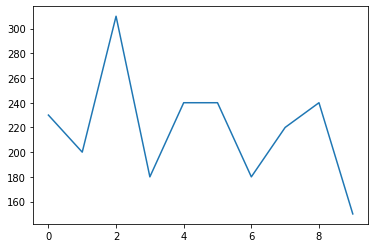

In [17]:
plt.plot(history)
plt.show()

In [18]:
#Visualization cobe for running within Colab

# Install dependencies first for graphics visualization within Colaboratory

#remove " > /dev/null 2>&1" to see what is going on under the hood
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1

Requirement already up-to-date: setuptools in /usr/local/lib/python3.6/dist-packages (47.3.1)


In [19]:
#To Evaluate model on OpenAI gym, we will record a video via Ipython display



from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only

import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay


from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

In [20]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [24]:
#Evaluate model on openAi GYM
env = wrap_env(gym.make('MsPacman-v0'))
observation = env.reset()
new_observation = observation

prev_input = None
done = False

with tf.compat.v1.Session() as sess:
    init.run()
    while True:
      if True: 
    
        #set input to network to be difference image
    

        obs = preprocess_observation(observation)

        # feed the game screen and get the Q values for each action
        actions = mainQ_outputs.eval(feed_dict={X:[obs], in_training_mode:False})

        # get the action
        action = np.argmax(actions, axis=-1)
        actions_counter[str(action)] += 1 

        # select the action using epsilon greedy policy
        action = epsilon_greedy(action, global_step)
        env.render()
        observation = new_observation        
        # now perform the action and move to the next state, next_obs, receive reward
        new_observation, reward, done, _ = env.step(action)

        if done: 
          #observation = env.reset()
          break
      
    env.close()
    show_video()

## 
--------------------------------------------------------

In [150]:
import numpy as np
import gym
import tensorflow as tf

from tensorflow.contrib.layers import flatten, conv2d, fully_connected
from collections import deque, Counter
import random
from datetime import datetime

AttributeError: ignored

In [ ]:
mspacman_color = np.array([210, 164, 74]).mean()

def preprocess_observation(obs):
    img = obs[1:176:2, ::2]
    img = img.mean(axis=2)
    img[img==mspacman_color] = 0
    img = (img - 128) / 128 - 1
    return img.reshape(88,80,1)

In [ ]:

tf.reset_default_graph()
env = gym.make("MsPacman-v0")

In [ ]:
n_outputs = env.action_space.n

def q_network(X, name_scope):
    initializer = tf.contrib.layers.variance_scaling_initializer()
    with tf.variable_scope(name_scope) as scope: 
        layer_1 = conv2d(X, num_outputs=32, kernel_size=(8,8), stride=4, padding='SAME', weights_initializer=initializer) 
        tf.summary.histogram('fc_1',fc_1)
        layer_2 = conv2d(layer_1, num_outputs=64, kernel_size=(4,4), stride=2, padding='SAME', weights_initializer=initializer)
        tf.summary.histogram('layer_2',layer_2)
        layer_3 = conv2d(layer_2, num_outputs=64, kernel_size=(3,3), stride=1, padding='SAME', weights_initializer=initializer)
        tf.summary.histogram('layer_3',layer_3)
        
        flat = flatten(layer_3)
        fc_1 = fully_connected(flat, num_outputs=128, weights_initializer=initializer)
        tf.summary.histogram('fc_1',fc_1)
        
        outputs = fully_connected(fc_1, num_outputs=n_outputs, activation_fn=None, weights_initializer=initializer)
        tf.summary.histogram('outputs',outputs)
        
        vrs = {v.name[len(scope.name):]: v for v in tf.get_collection(key=tf.GraphKeys.TRAINABLE_VARIABLES, scope=scope.name)} 
        return vrs, outputs

In [ ]:
maxlen = 20000
def get_memories(batch_size):
    perm_batch = np.random.permutation(len(memories))[:batch_size]
    mem = np.array(memories)[perm_batch]
    return mem[:,0], mem[:,1], mem[:,2], mem[:,3], mem[:,4]

epsilon = 0.5
eps_min = 0.05
eps_max = 1.0
eps_decay_steps = 500000

def expl_policy(action, step, print_ep=False):
    p = np.random.random(1).squeeze()
    epsilon = max(eps_min, eps_max - (eps_max-eps_min) * step/eps_decay_steps)
    if print_ep:
        print('Epsilon:',epsilon)
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)
    else:
        return action

In [ ]:
num_games = 800
batch_size = 48
global_step = 0
print_ep = 10
input_shape = (None, 88, 80, 1)
learning_rate = 0.001
X_shape = (None, 88, 80, 1)
discount_factor = 0.97
copy_steps = 100
steps_train = 4
start_steps = 2000

now = datetime.utcnow().strftime("%Y/%m/%d-%H-%M-%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)

tf.reset_default_graph()

memories = deque(maxlen=maxlen)

X = tf.placeholder(tf.float32, shape=X_shape)
in_training_mode = tf.placeholder(tf.bool)

mainQ, mainQ_outputs = q_network(X, 'mainQ')
secondQ, secondQ_outputs = q_network(X, 'secondQ')


X_action = tf.placeholder(tf.int32, shape=(None,))
Q_action = tf.reduce_sum(secondQ_outputs * tf.one_hot(X_action, n_outputs), axis=-1, keep_dims=True)

copy_op = [tf.assign(main_name, secondQ[var_name]) for var_name, main_name in mainQ.items()]
copy_second_to_main = tf.group(*copy_op)

y = tf.placeholder(tf.float32, shape=(None,1))
loss = tf.reduce_mean(tf.square(y - Q_action))
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)


init = tf.global_variables_initializer()

loss_summary = tf.summary.scalar('LOSS', loss) #loss_summary
merge_summary = tf.summary.merge_all()
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [ ]:
print(learning_rate)
with tf.Session() as sess:
    init.run()
    
    for i in range(num_games):
        done = False
        obs = env.reset()
        epoch = 0
        game_reward = 0
        actions_counter = Counter() 
        game_loss = []
        
        while not done:
            obs = preprocess_observation(obs)
            actions = mainQ_outputs.eval(feed_dict={X:[obs], in_training_mode:False})

            ## GET THE ACTION
            action = np.argmax(actions, axis=-1)
            actions_counter[str(action)] += 1 
            action = expl_policy(action, global_step)
            
            new_obs, reward, done, _ = env.step(action)

            ## ADD THE LAST MEMORIES IN THE EXPERIENCE MEMORIES STRUCTURE
            memories.append([obs, action, preprocess_observation(new_obs), reward, done])
            
            
            if global_step % steps_train == 0 and global_step > start_steps:
                ## TRAIN THE SECOND Q
                o_obs, o_act, o_next_obs, o_rew, o_done = get_memories(batch_size)

                o_obs = [x for x in o_obs]
                o_next_obs = [x for x in o_next_obs]

                next_act = mainQ_outputs.eval(feed_dict={X:o_next_obs, in_training_mode:False})
                y_batch = o_rew + discount_factor * np.max(next_act, axis=-1) * (1-o_done) 
            
                mrg_summary = merge_summary.eval(feed_dict={X:o_obs, y:np.expand_dims(y_batch, axis=-1), X_action:o_act, in_training_mode:False})
                file_writer.add_summary(mrg_summary, global_step)

                train_loss, _ = sess.run([loss, training_op], feed_dict={X:o_obs, y:np.expand_dims(y_batch, axis=-1), X_action:o_act, in_training_mode:True})
                game_loss.append(train_loss)
            
            ## COPY THE SECONDQ IN THE MAINQ
            if (global_step+1) % copy_steps == 0 and global_step > start_steps:
                copy_second_to_main.run()
                
            
            obs = new_obs
            epoch += 1
            global_step += 1
            game_reward += reward
        
        print('----', i, '---', epoch, '--', game_reward,'----', np.mean(game_loss), '----')
        expl_policy(3, global_step, print_ep=True)
        print(actions_counter)
        
        ## TEST THE MAIN Q
        obs = env.reset()
        test_ep = 0
        test_reward = 0
        test_done = False
        test_actions_counter = Counter() 
        while not test_done:
            obs = preprocess_observation(obs)
            action = mainQ_outputs.eval(feed_dict={X:[obs], in_training_mode:False})
            test_actions_counter[str(np.argmax(action))] += 1 
            new_obs, reward, test_done, _ = env.step(np.argmax(action))
            
            obs = new_obs
            test_ep += 1
            test_reward += reward
            
        print('TEST:', test_ep, '\t', test_reward, test_actions_counter)